# Tesis de Licenciatura en Astronomía

## Manuel López Vargas

# Detección de señales en series de tiempo astronómicas utilizando algoritmos de Machine Learning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.signal as signal
from astropy.timeseries import LombScargle
from gatspy.periodic import LombScargleFast
from gatspy import datasets, periodic
import sympy
from scipy.integrate import odeint
from scipy import integrate
from mpl_toolkits.mplot3d.axes3d import Axes3D
import random
from operator import itemgetter
from matplotlib.ticker import MultipleLocator
from scipy import stats

In [2]:
A = 3
B = 4
C = 2
w1 = 3.2 #rad/sec
w2 = 2.300 #rad/sec
w3 = 4 #rad/sec
psi1 = 1. #rad
psi2 = 1.8 #rad
n_out = 10000

Generamos aleatoriamente tiempos de muestreo.

In [90]:
seed_value = 1 
rng = np.random.default_rng(seed_value)
t = rng.uniform(0, 135, 100)


In [91]:
wave = A * np.sin(w1*t + psi1) + B * np.sin(w2*t + psi2)

Definimos un arreglo de frecuencias para el que se calculará el periodograma

In [92]:
w = np.linspace(0.0001, 10, n_out)
periods = 2 * np.pi / w

Calculamos el error en frecuencia

In [93]:
err = w[1]-w[0]
err

0.0010000900090009002

Calculo el Lomb-Scargle periodograma

In [94]:
pgram = signal.lombscargle(t, wave, w, normalize=True)

Ploteo los datos de salida

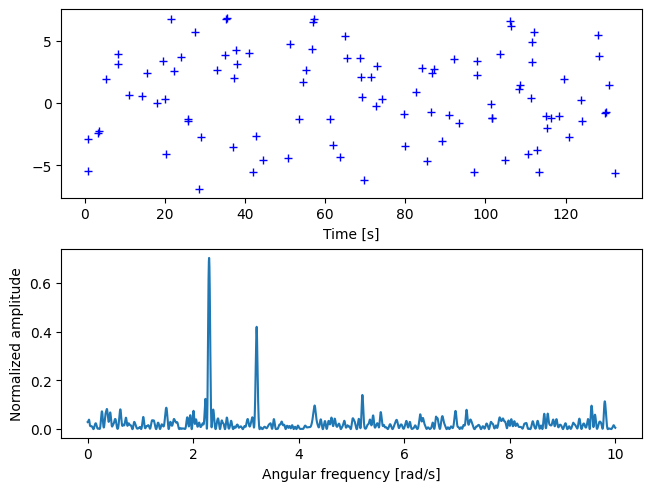

In [95]:
fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, wave, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude');

Calculamos el valor de los dos picos

In [96]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index], err)

La frecuencia encontrada es 2.3013071107110714 0.0010000900090009002


In [97]:
pgram2 = np.where(w> 2.6, pgram, pgram*0)

pgram_sort = sorted(enumerate(pgram2), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index], err)

La frecuencia encontrada es 3.202388208820883 0.0010000900090009002


### Señal con ruido

Simulamos una distribución gaussiana para generar el ruido

In [138]:
sigma = 0.2*A

In [139]:
w_noise = np.random.default_rng(2).normal(0, sigma , 100)

Calculamos nuestra señal con ruido

In [140]:
wave_n =  A * (np.sin(w1*t + psi1) + w_noise)  + B * (np.sin(w2*t + psi2) + w_noise)

Calculamos el periodograma

In [141]:
pgram = signal.lombscargle(t, wave_n, w, normalize=True)

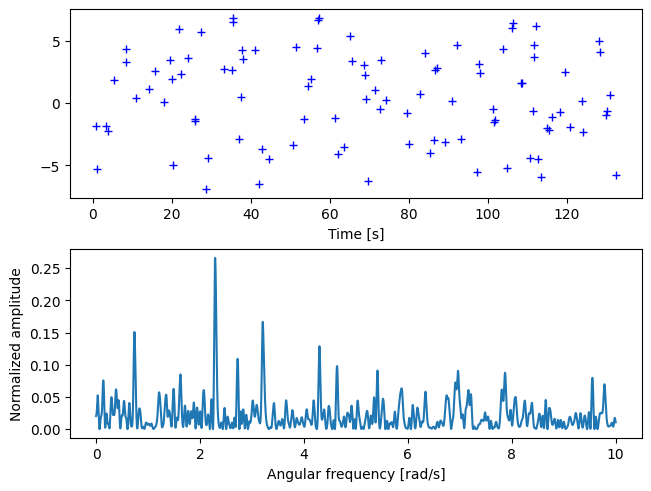

In [142]:
fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, x_n, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude');

Calculamos el valor de los dos picos.

In [143]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index], err)

La frecuencia encontrada es 2.2923063006300635 0.0010000900090009002


In [144]:
pgram2 = np.where(w> 2.6, pgram, pgram*0)

pgram_sort = sorted(enumerate(pgram2), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index], err)

La frecuencia encontrada es 3.208388748874888 0.0010000900090009002


#### Calculamos la False-Alarm Probablility (FAP).

La FAP se define como FAP(z) = $1 - [P_{single0}(z)]^{N_{eff.}}$ donde $N_{eff.}= f_{max}T$

Utilizando la libreria astropy.timeseries vamos a calcular la FAP.

In [145]:
ls = LombScargle(t, wave_n, normalization='standard')
power = ls.power(w)
print(power.max())  

0.2635681139819884


In [146]:
fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

FAP = 0.0003924735313645017


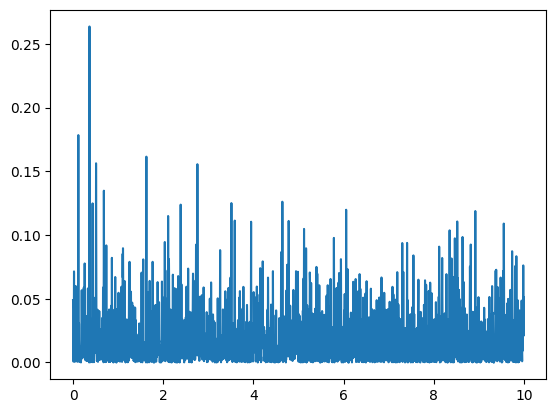

In [147]:
plt.plot(w,power);

In [148]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.1687197 , 0.18172519, 0.21024363])

#### Vemos como cambia el error en la obtención de la frecuencia en función de la cantidad de observaciones:

In [149]:
def error_cant_obs1(nu_1, nu_2, nmax):

    res = []
    res1 = []
    t_max = []

    for i in range(30, nmax, 10):
        
        rng = np.random.default_rng(1)
        t = rng.uniform(0, 30, i)
        t.sort()
        w = np.linspace(0.0001, 10, n_out)

        n = np.random.default_rng(3).normal(0, 0.2*A , i)
        
        xx = A * (np.sin(w1*t + psi1) + n) + B * (np.sin(w2*t + psi2) + n)
        
        pgram = signal.lombscargle(t, xx, w, normalize=True)

        pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
        index, value = pgram_sort[0]
        
        pgram2 = np.where(w> 2.6, pgram, pgram*0)

        pgram_sort = sorted(enumerate(pgram2), key=itemgetter(1),  reverse=True)
        index1, value = pgram_sort[0]
    
        nu1 = abs(w[index]-nu_1)
        
        nu2 = abs(w[index1]-nu_2)
        
        res.append(nu1)
        
        res1.append(nu2)
    
        t_max.append(i)

    return(res,res1,t_max)

In [150]:
error0 = error_cant_obs1(2.3 ,3.2, 1000)
res = error0[0]
res1 = error0[1]
t_max = error0[2]

In [151]:
t_max = np.array(t_max)    
res1 = np.array(res1)
res = np.array(res)

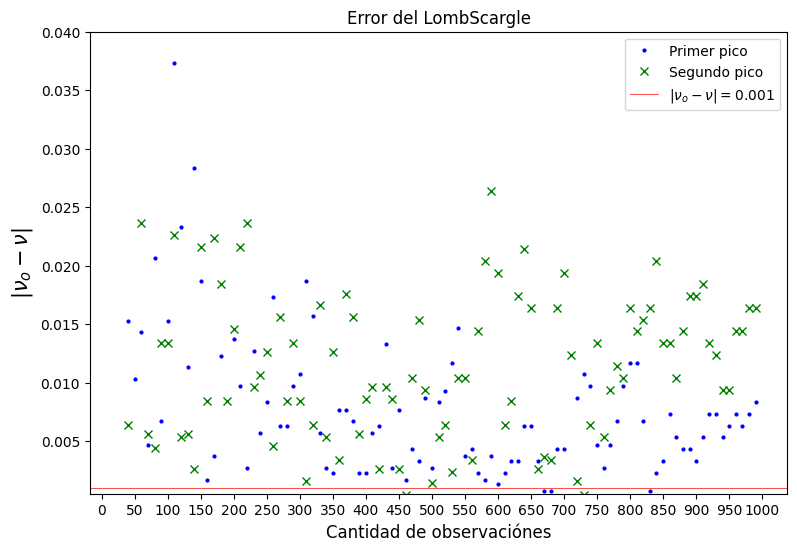

In [154]:
fig, ax = plt.subplots(1,1, figsize=(9,6))

ax.plot(t_max,res, 'o', ms=2, color='blue', label='Primer pico')
ax.plot(t_max, res1,'x', color='green', label='Segundo pico')
ax.set_xlabel('Cantidad de observaciónes', fontsize=12)
ax.set_ylabel(r'$ |\nu_o-\nu|$', fontsize=15)
ax.set_title('Error del LombScargle')
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.axhline(0.001, color= 'red' ,lw=0.5, label=r'$|\nu_o-\nu|=0.001$')
ax.legend(loc = 'upper right')
ax.set_ylim(0.0005,0.04);

#### Vemos como cambia el error en la obtención de la frecuencia en función de la longitud del intervalo de observacion:

In [155]:
def error_int_obs1(nu_1,nu_2, nmax, j): # j es la cantidad de observaciones

    res = []

    res1 = []
    
    t_max = []
    
    coc = []
    
    for i in range(10, nmax, 5):
        
        rng = np.random.default_rng(1)
        t = rng.uniform(0, i, j)
        t.sort()
        w = np.linspace(0.0001, 10, n_out)

        pgram = 0
        
        n = np.random.default_rng(3).normal(0, 0.2*A , j)

        xx= A * (np.sin(w1*t + psi1) + n) + B * (np.sin(w2*t + psi2) + n)
        
        pgram = signal.lombscargle(t, xx, w, normalize=True)

        pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
        index, value = pgram_sort[0]
        
        pgram2 = np.where(w> 2.6, pgram, pgram*0)

        pgram_sort = sorted(enumerate(pgram2), key=itemgetter(1),  reverse=True)
        index1, value = pgram_sort[0]
    
        nu1 = abs(w[index]-nu_1)
        
        nu2 = abs(w[index1]-nu_2)
        
        res.append(nu1)
        
        res1.append(nu2)
    
        t_max.append(i)
        
        if j==nmax:
            
            coc.append(j/i)

    return(res, res1, t_max, coc)

In [156]:
error00 = error_int_obs1(2.3 ,3.2, 300, 300)
res0 = error00[0]
res01 = error00[1]
t_max0 = error00[2]
coc0 = error00[3]

In [157]:
t_max0 = np.array(t_max0)    
res01 = np.array(res01)
res0 = np.array(res0)
coc0 = np.array(coc0)

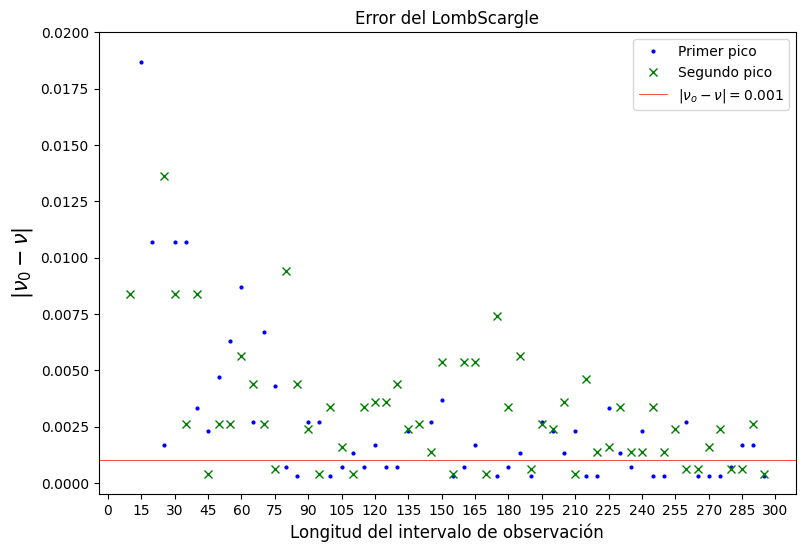

In [158]:
fig, ax = plt.subplots(1,1 ,figsize=(9,6))

ax.plot(t_max0,res0, 'o', ms=2,color='blue', label='Primer pico')
ax.plot(t_max0,res01,'x' ,color='green', label='Segundo pico')
ax.set_xlabel('Longitud del intervalo de observación', fontsize=12)
ax.set_ylabel(r'$ |\nu_0-\nu|$', fontsize=15)
ax.set_title('Error del LombScargle')
plt.xticks(fontsize=10)
ax.xaxis.set_major_locator(MultipleLocator(15))
ax.set_ylim(-0.0005,0.02)
ax.axhline(0.001, color= 'red' ,lw=0.5, label=r'$|\nu_o-\nu|=0.001$')
ax.legend(loc = 'upper right');

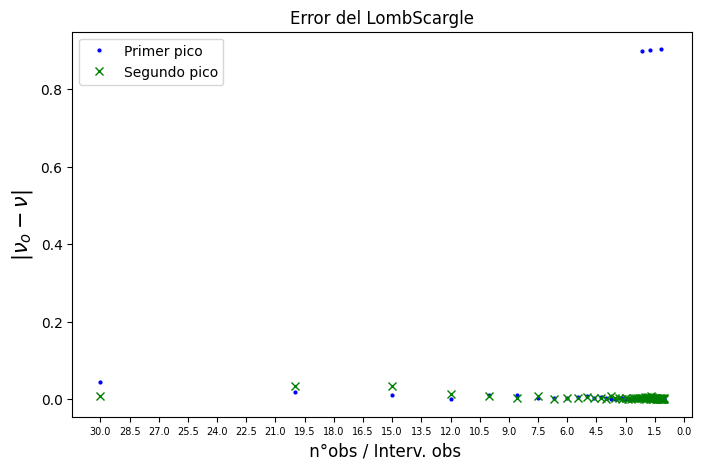

In [159]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(coc0,res0,'o',ms =2, color='blue', label='Primer pico')
ax.plot(coc0,res01,'x' ,color='green', label='Segundo pico')
ax.set_xlabel(' n°obs / Interv. obs', fontsize=12)
ax.set_ylabel(r'$| \nu_o-\nu | $', fontsize=15)
ax.set_title('Error del LombScargle')
ax.invert_xaxis()
ax.xaxis.set_major_locator(MultipleLocator(1.5))
plt.xticks(fontsize=7)
ax.legend(loc = 'upper left');

## Ahora simularemos nuestros datos utilizando potenciales con simetria esférica.

### Probamos primero con el siguiente potencial:

### $\phi(r) = -\frac{GM}{r} $

Luego

### $\ddot{x} = - \nabla \phi(r)$

Podemos descomponer esta ecuación diferencial de segundo orden en dos ecuaciones de primer orden.

### $\dot{x} = v\ \ \ ,\ \ x(0) = x_0$
### $\dot{v} = -\nabla \phi\ \ \ , \ \ \dot{x}(0) = \dot{x}_0$

Planteamos las condiciones iniciales.

### $X_o$=1  ,   $Y_o$=0
### $\dot{X_0}$=0  ,   $\dot{Y_0}$=0.1

### GM=1

Resolvemos las ecuaciones diferenciales acopladas de forma numérica:

In [602]:
# Elegimos los tiempos de observación t
seed_value = 10 
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 40, 80)

In [601]:
t.sort()

In [419]:
# Definimos el sistema de ecuaciones

def ec_dif1(t):

    def f1(xyv_xv_y, t):
        x, y, v_x, v_y = xyv_xv_y
        return [v_x, 
               v_y,
               -x/(x**2+y**2)**(3/2),
               -y/(x**2+y**2)**(3/2)]


    # Condiciónes iniciales
    xyv_xv_y0 = [1.0, 0., 0., 0.1]

    # Resolvemos las ecuaciones
    xyv_xv_y1 = integrate.odeint(f1, xyv_xv_y0, t)
    
    x_1 = xyv_xv_y1[:,0]
    y_1 = xyv_xv_y1[:,1]
    v_x_1 = xyv_xv_y1[:,2]
    v_y_1 = xyv_xv_y1[:,3]
    
    return(x_1,y_1,v_x_1,v_y_1)

In [420]:
x_1 = ec_dif1(t)[0]
y_1 = ec_dif1(t)[1]
v_x_1 = ec_dif1(t)[2]
v_y_1 = ec_dif1(t)[3]

In [421]:
#Calculamos la distancia el perihelio

a = (np.max(x_1)-np.min(x_1))/2 #semi eje mayor
b = np.max(y_1) #semi eje menor
e = np.sqrt(a**2-b**2)/a #excentricidad

p = a*(1+e) #posicion el perihelio
r_p = p-a #radio del perihelio

Simulamos una distribución Gaussiana para generar el ruido de las observaciones.

In [422]:
sigma = 0.2*r_p #disviación 
noise_x = np.random.default_rng(4).normal(0, sigma , 80) #ruido gaussiano para el eje x
noise_y = np.random.default_rng(5).normal(0, sigma*0.2 , 80) #ruido gaussiano para el eje y

In [423]:
x_n = x_1 + noise_x
y_n = y_1 + noise_y

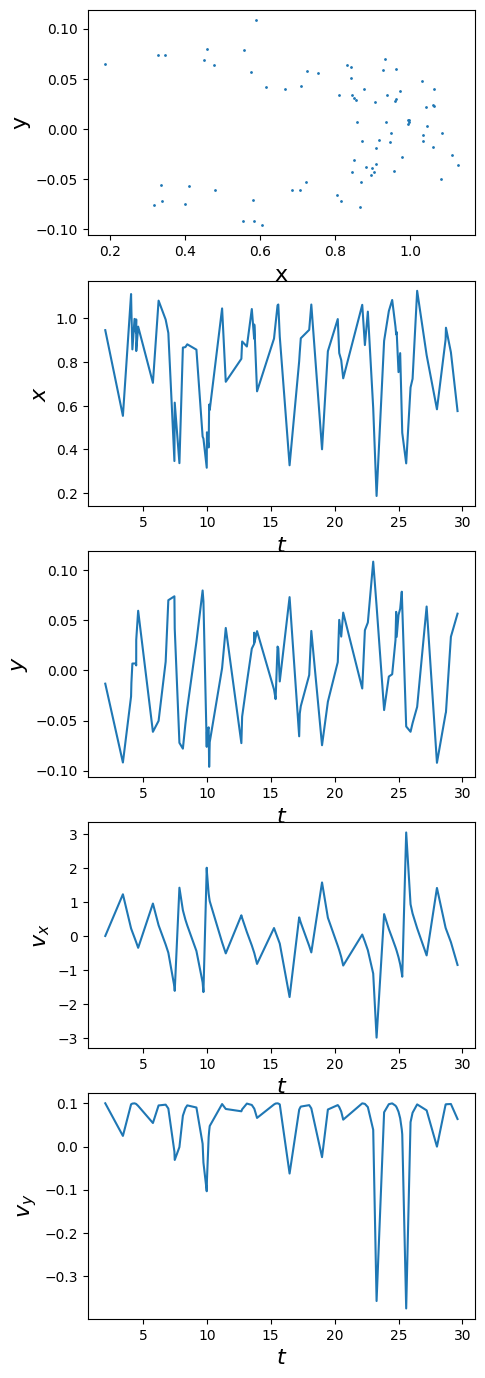

In [424]:
# Graficamos las soluciones

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(5,17))

ax1.plot(x_n,y_n, 'o', ms=1)
ax2.plot(t, x_n)
ax3.plot(t, y_n)
ax4.plot(t, v_x_1)
ax5.plot(t, v_y_1)

ax1.set_ylabel('y', fontsize=16)
ax1.set_xlabel('x', fontsize=16)
ax2.set_xlabel('$t$', fontsize=16)
ax3.set_xlabel('$t$', fontsize=16)
ax4.set_xlabel('$t$', fontsize=16)
ax5.set_xlabel('$t$', fontsize=16)
ax2.set_ylabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax4.set_ylabel('$v_x$', fontsize=16)
ax5.set_ylabel('$v_y$', fontsize=16);

Con esto, calculamos el periodograma para las coordenadas x e y:

Las unicas variables con ruido son las coordenadas x e y

#### Coordenada X

In [425]:
# Definimos el espacio de frecuencias a analizar

w = np.linspace(0.0001, 10, n_out)
periods = 2 * np.pi / w

# Calculamos el error en frecuencia
err= w[1]-w[0]
err

0.0010000900090009002

In [426]:
xx= x_n-x_n.mean()

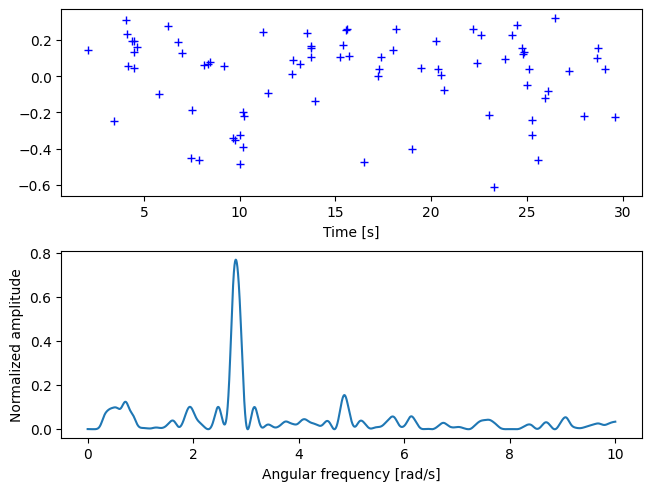

In [427]:
#Calculamos el periodograma y graficamos

pgram = signal.lombscargle(t, xx, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, xx, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude');

Buscamos el valor de la frecuencia del pico mas alto:

In [428]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 2.807352655265527 0.0010000900090009002


In [429]:
#El error cometido es
(w[index] - 2.8072)

0.00015265526552710185

In [430]:
ls = LombScargle(t, xx, normalization='standard')
power = ls.power(w)
print('Altura del pico máximo:',power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

Altura del pico máximo: 0.8169774120248883
FAP = 1.087222982146632e-25


In [431]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.20259433, 0.21832532, 0.2525771 ])

Vemos que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,1303; para el 5%, 0,1403, y para el 1%, 0,1624.

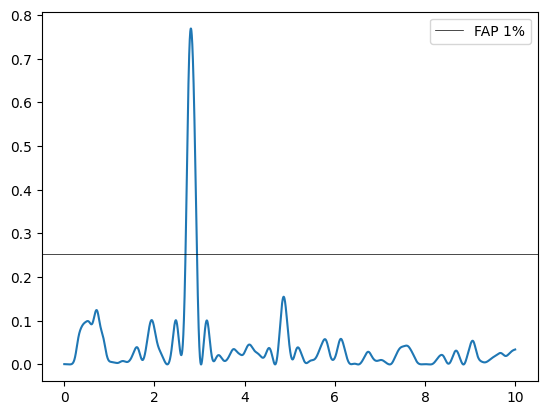

In [432]:
plt.plot(w,pgram)
plt.axhline(0.2525, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron dos picos con una FAP menos a 1%. Pero la que nos interes es el pico mas alto.

#### Coordenada Y

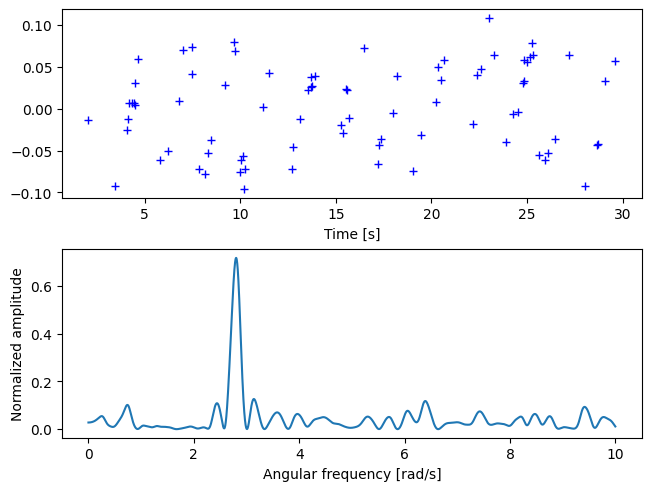

In [433]:
pgram = signal.lombscargle(t, y_n, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, y_n, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude');

Buscamos el valor de la frecuencia del pico mas alto:

In [434]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 2.8033522952295233 0.0010000900090009002


In [435]:
#El error cometido es
abs(w[index]-2.8072)

0.0038477047704765788

El segundo pico es multiplo del pico principal, por lo que nos nos interesa

In [436]:
ls = LombScargle(t, y_n, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.7246996333848436
FAP = 5.595270706460461e-19


In [437]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.20259433, 0.21832532, 0.2525771 ])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,1303; para el 5%, 0,1403, y para el 1%, 0,1624.

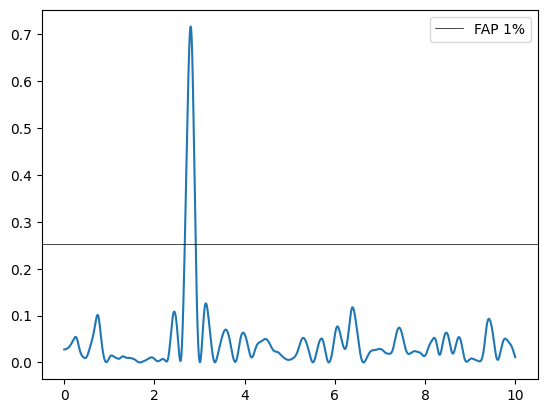

In [438]:
plt.plot(w,pgram)
plt.axhline(0.2525, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron tres picos con una FAP menos a 1%. Pero la que nos interes es el pico mas alto.

#### Vemos como cambia el error en la obtención de la frecuencia en función de la cantidad de observaciones:

In [567]:
def error_cant_obs(nu_0, nmax, ec, sigma, seed):

    res = []

    t_max = []

    for i in range(40, nmax, 10):
        
        rng = np.random.default_rng(10)
        t = rng.uniform(0, 30, i)
        t.sort()
        w = np.linspace(0.0001, 10, n_out)

        if ec == 1:
        
            sol = ec_dif1(t)
            
        else:

            sol = ec_dif2(t)
        
        pgram = 0
        
        n = np.random.default_rng(seed).normal(0, sigma , i) #ruido gaussiano para el eje x

        x = sol[0] + n

        if ec==1:
            
            xx= x-x.mean()

        else:

            xx = x
        
        pgram = signal.lombscargle(t, xx, w, normalize=True)

        pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
        index, value = pgram_sort[0]
    
        nu = abs(w[index]-nu_0)
        res.append(nu)
    
        t_max.append(i)

    return(res,t_max)

In [562]:
error1 = error_cant_obs(2.8072, 1000,1, sigma, 4)
res = error1[0]
t_max = error1[1]

In [563]:
t_max = np.array(t_max)    
    
res = np.array(res)

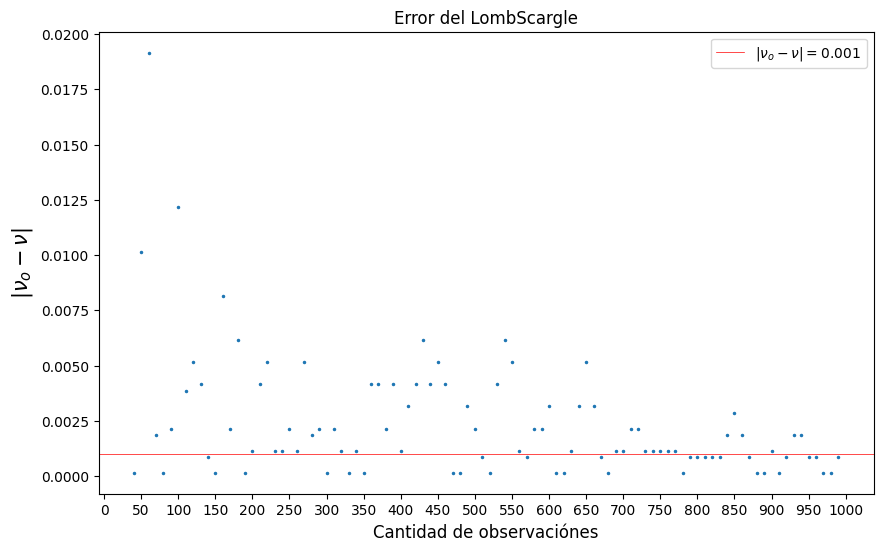

In [564]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(t_max,res,'o', ms=1.5)
ax.set_xlabel('Cantidad de observaciónes', fontsize=12)
ax.set_ylabel(r'$ |\nu_o-\nu|$', fontsize=15)
ax.set_title('Error del LombScargle')
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.axhline(0.001, color= 'red' ,lw=0.5, label=r'$|\nu_o-\nu|=0.001$')
ax.legend(loc = 'upper right');

#### Vemos como cambia el error en la obtención de la frecuencia en función de la longitud del intervalo de observacion:

In [574]:
def error_int_obs(nu_0, nmax, j, ec, sigma, seed): # j es la cantidad de observaciones

    res = []

    t_max = []
    
    coc = []
    
    for i in range(10, nmax, 5):
        
        rng = np.random.default_rng(10)
        t = rng.uniform(0, i, j)
        t.sort()
        w = np.linspace(0.0001, 10, n_out)

        if ec==1:
            
            sol = ec_dif1(t)
        else:

            sol = ec_dif2(t)
            
        pgram = 0       
        n = np.random.default_rng(seed).normal(0, sigma , j) #ruido gaussiano para el eje x

        
        x = sol[0] + n

        if ec==1:
            
            xx= x-x.mean()

        else:

            xx = x
        
        pgram = signal.lombscargle(t, xx, w, normalize=True)

        pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
        index, value = pgram_sort[0]
    
        nu = abs(w[index]-nu_0)
        
        res.append(nu)
    
        t_max.append(i)
        
        if j==nmax:
            
            coc.append(j/i)

    return(res,t_max, coc)

In [557]:
error2 = error_int_obs(2.8072, 100, 300, 1, sigma, 4)
res2 = error2[0]
t_max2 = error2[1]
coc = error2[2];

In [558]:
t_max2 = np.array(t_max2)    
    
res2 = np.array(res2)

coc = np.array(coc)

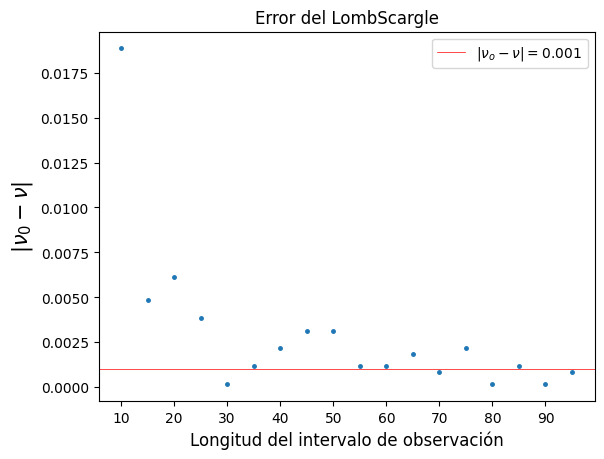

In [560]:
fig, ax = plt.subplots()

ax.plot(t_max2,res2, 'o', ms=2.5)
ax.set_xlabel('Longitud del intervalo de observación', fontsize=12)
ax.set_ylabel(r'$ |\nu_0-\nu|$', fontsize=15)
ax.set_title('Error del LombScargle')
plt.xticks(fontsize=10)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.axhline(0.001, color= 'red' ,lw=0.5, label=r'$|\nu_o-\nu|=0.001$')
ax.legend(loc = 'upper right');

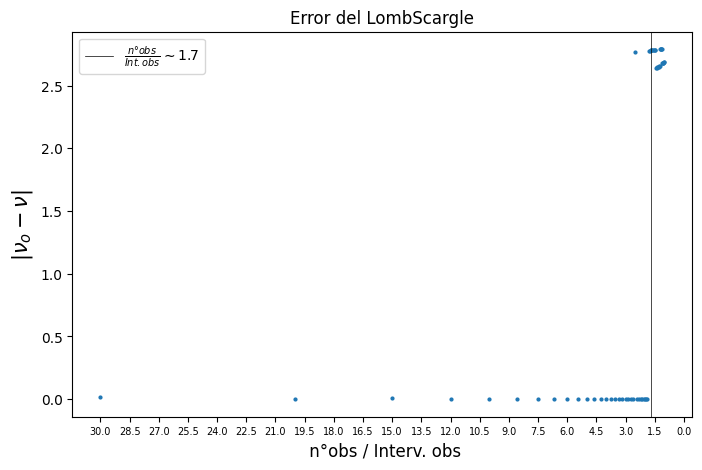

In [357]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(coc,res2, 'o', ms=2)
ax.set_xlabel(' n°obs / Interv. obs', fontsize=12)
ax.set_ylabel(r'$ | \nu_o-\nu |$', fontsize=15)
ax.set_title('Error del LombScargle')
ax.invert_xaxis()
ax.xaxis.set_major_locator(MultipleLocator(1.5))
plt.xticks(fontsize=7)
ax.axvline(1.7, color= 'black' ,lw=0.5, label=r'$\frac{n°obs}{Int.obs}\sim1.7$')
ax.legend(loc = 'upper left');

## Pasamos a un potencial de la forma:

### $\phi =\frac{1}{2} \Omega² r²$

#### Luego, resolvemos el mismo sistema de ec. diferenciales para el $\phi$ mencionado.

In [127]:
# Elegimos los tiempos de observación t
seed_value = 20
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 40, 40)

In [128]:
t.sort()

In [129]:
# Definimos el sistema de ecuaciones

def ec_dif2(t):
    
    def f2(xyv_xv_y, t, a, omega):
        x, y, v_x, v_y = xyv_xv_y
        return [v_x, 
               v_y,
                a-(omega**2) * x,
                a-(omega**2) * y]


    # Condiciónes iniciales
    xyv_xv_y0 = [1., 0., 0., 0.1]
    omega=np.sqrt(2)
    a=0

    # Resolvemos las ecuaciones
    xyv_xv_y2 = integrate.odeint(f2, xyv_xv_y0, t, args=(a, omega))
    
    x_2 = xyv_xv_y2[:,0]
    y_2 = xyv_xv_y2[:,1]
    v_x_2 = xyv_xv_y2[:,2]
    v_y_2 = xyv_xv_y2[:,3]
    
    return(x_2,y_2,v_x_2,v_y_2)

In [130]:
x_2 = ec_dif2(t)[0]
y_2 = ec_dif2(t)[1]
v_x_2 = ec_dif2(t)[2]
v_y_2 = ec_dif2(t)[3]

In [131]:
#Calculamos la distancia el perihelio

a2 = np.max(x_2) #semi eje mayor
b2= np.max(y_2) #semi eje menor
e2 = np.sqrt(a2**2-b2**2)/a2 #excentricidad

p2 = a2*(1+e2) #posicion el perihelio
r_p2 = p2-a2 #radio del perihelio

Simulamos una distribución Gaussiana para generar el ruido de las observaciones.

In [132]:
sigma1 = 0.1*r_p2 #disviación 
noise2_x = np.random.default_rng(6).normal(0, sigma1 , 40) #ruido gaussiano para el eje x
noise2_y = np.random.default_rng(7).normal(0, sigma1*0.2 , 40) #ruido gaussiano para el eje y

In [133]:
x2_n = x_2 + noise2_x
y2_n = y_2 + noise2_y

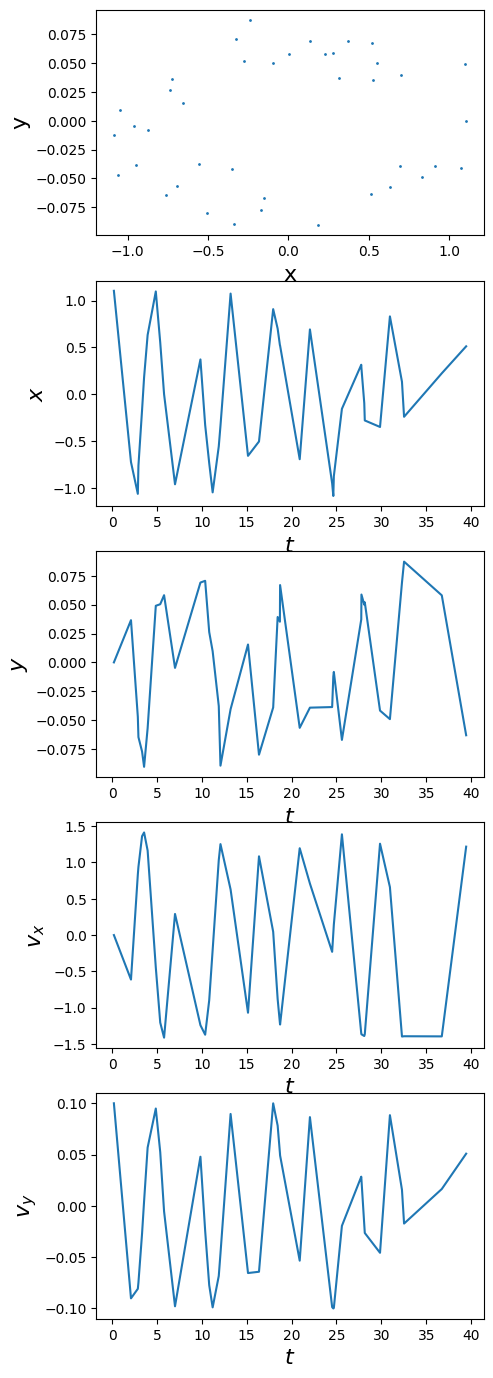

In [134]:
# Graficamos las soluciones

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(5,17))

ax1.plot(x2_n,y2_n, 'o', ms=1)
ax2.plot(t, x2_n)
ax3.plot(t, y2_n)
ax4.plot(t, v_x_2)
ax5.plot(t, v_y_2)

ax1.set_ylabel('y', fontsize=16)
ax1.set_xlabel('x', fontsize=16)
ax2.set_xlabel('$t$', fontsize=16)
ax3.set_xlabel('$t$', fontsize=16)
ax4.set_xlabel('$t$', fontsize=16)
ax5.set_xlabel('$t$', fontsize=16)
ax2.set_ylabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax4.set_ylabel('$v_x$', fontsize=16)
ax5.set_ylabel('$v_y$', fontsize=16);

Con esto, calculamos el periodograma para las coordenadas x e y:

Una vez más, las unicas variables con ruido son las coordenadas x e y

#### Coordenada X

In [135]:
# Definimos el espacio de frecuencias a analizar

w = np.linspace(0.0001, 10, n_out)
periods = 2 * np.pi / w

# Calculamos el error en frecuencia
err= w[1]-w[0]
err

0.0010000900090009002

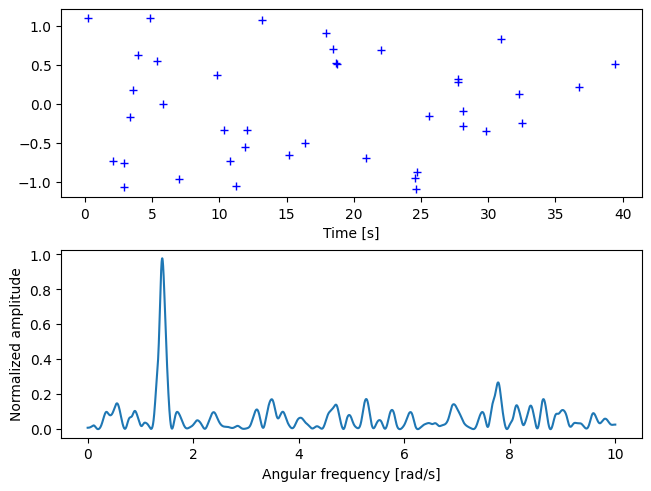

In [136]:
pgram = signal.lombscargle(t, x2_n, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, x2_n, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude');

Buscamos el valor de la frecuencia del pico mas alto:

In [137]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 1.413227182718272 0.0010000900090009002


In [138]:
#El error comedito es
abs(w[index]-1.4142)

0.0009728172817278224

In [618]:
ls = LombScargle(t, x_2, normalization='standard')
power = ls.power(w)
print('Altura del pico máximo:',power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

Altura del pico máximo: 0.9999892048729108
FAP = 1.6800036208862203e-87


In [619]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)

array([0.35091084, 0.37761927, 0.43367227])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,3509; para el 5%, 0,3776, y para el 1%, 0,4336.

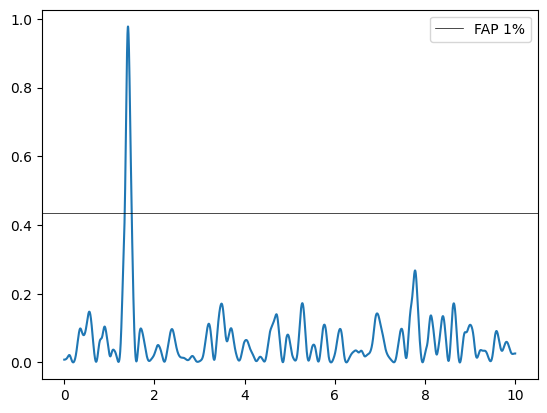

In [621]:
plt.plot(w,pgram)
plt.axhline(0.4336, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontro un solo pico con un FAP menor al 1%.

#### Coordenada Y

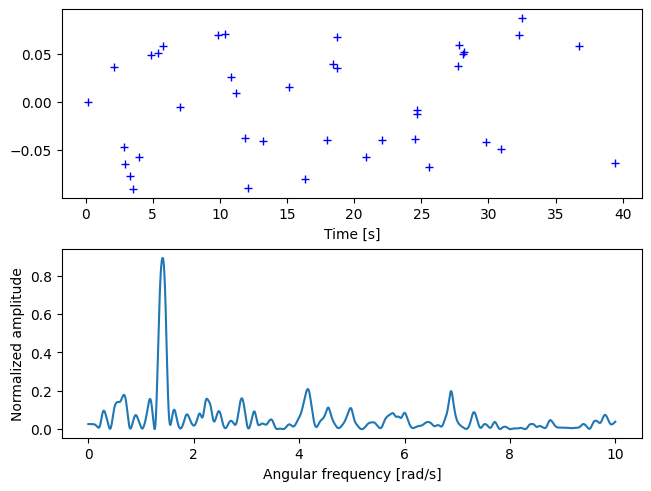

In [622]:
pgram = signal.lombscargle(t, y2_n, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, y2_n, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude');

Buscamos el valor de la frecuencia del pico mas alto:

In [623]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 1.4102269126912692 0.0010000900090009002


In [624]:
#El error comedito es
abs(w[index]-1.4142)

0.003973087308730694

In [625]:
ls = LombScargle(t, y_2, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.9999951718115693
FAP = 8.616413351717518e-94


In [626]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.35091084, 0.37761927, 0.43367227])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,3509; para el 5%, 0,3776, y para el 1%, 0,4336.


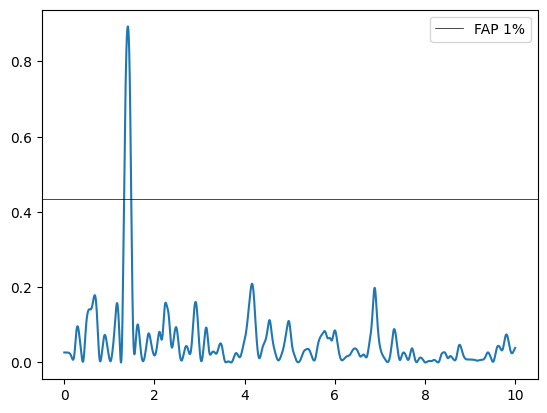

In [627]:
plt.plot(w,pgram)
plt.axhline(0.4336, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontro un solo pico con un FAP menor al 1%.

#### Vemos como cambia el error en la obtención de la frecuencia en función de la cantidad de observaciones:

In [568]:
error3 = error_cant_obs(1.4142, 1000, 0, sigma1, 6)
res3 = error3[0]
t_max3 = error3[1]

In [569]:
t_max3 = np.array(t_max3)    
    
res3 = np.array(res3)

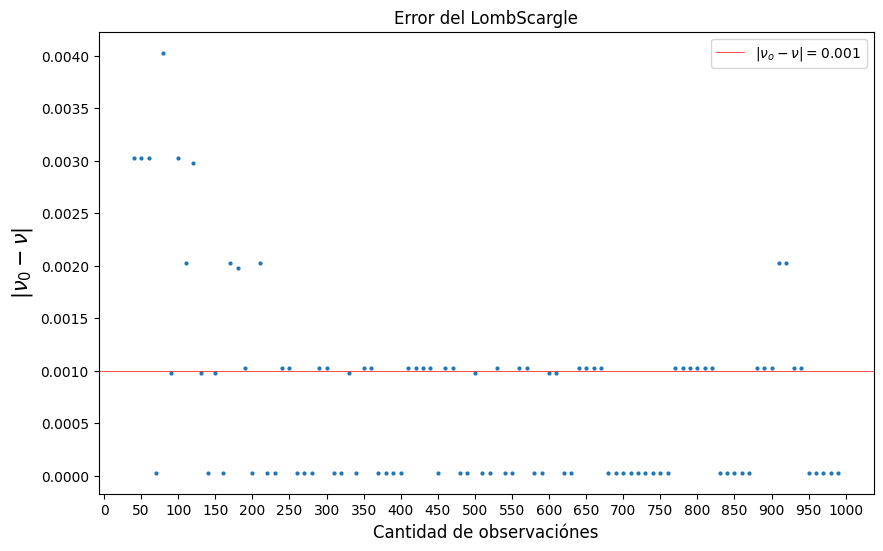

In [570]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(t_max3,res3, 'o',ms=2)
ax.set_xlabel('Cantidad de observaciónes', fontsize=12)
ax.set_ylabel(r'$ |\nu_0-\nu|$', fontsize=15)
ax.set_title('Error del LombScargle')
ax.axhline(0.001, color= 'red' ,lw=0.5, label=r'$|\nu_o-\nu|=0.001$')
ax.legend(loc = 'upper right')
ax.xaxis.set_major_locator(MultipleLocator(50));

#### Vemos como cambia el error en la obtención de la frecuencia en función de la longitud del intervalo de observacion:

In [598]:
error4 = error_int_obs(1.4142, 300, 300, 0, sigma1, 6)
res4 = error4[0]
t_max4 = error4[1]
coc1 = error4[2];

In [582]:
t_max4 = np.array(t_max4)    
    
res4 = np.array(res4)

coc1 = np.array(coc1)

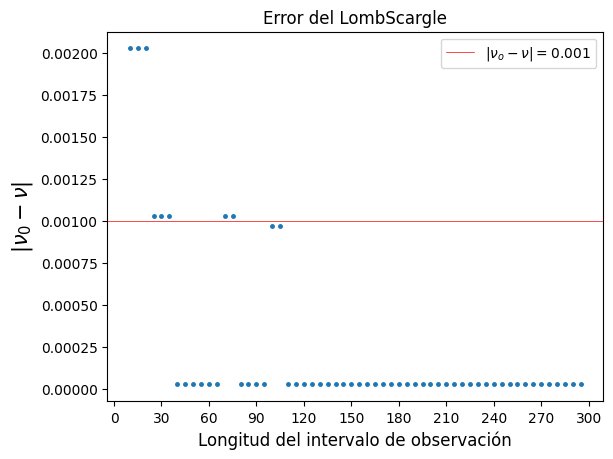

In [597]:
fig, ax = plt.subplots()

ax.plot(t_max4,res4, 'o', ms=2.5)
ax.set_xlabel('Longitud del intervalo de observación', fontsize=12)
ax.set_ylabel(r'$ |\nu_0-\nu|$', fontsize=15)
ax.set_title('Error del LombScargle')
plt.xticks(fontsize=10)
ax.xaxis.set_major_locator(MultipleLocator(30))
ax.axhline(0.001, color= 'red' ,lw=0.5, label=r'$|\nu_o-\nu|=0.001$')
ax.legend(loc = 'upper right');

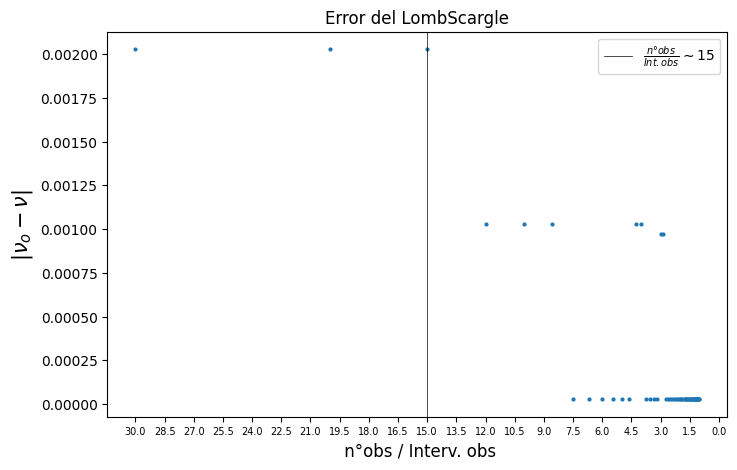

In [594]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(coc1,res4, 'o', ms=2)
ax.set_xlabel(' n°obs / Interv. obs', fontsize=12)
ax.set_ylabel(r'$ | \nu_o-\nu |$', fontsize=15)
ax.set_title('Error del LombScargle')
ax.invert_xaxis()
ax.xaxis.set_major_locator(MultipleLocator(1.5))
plt.xticks(fontsize=7)
ax.axvline(15, color= 'black' ,lw=0.5, label=r'$\frac{n°obs}{Int.obs}\sim15$')
ax.legend(loc = 'upper right');

### Pasamos ahora a un potencial de la forma:

### $\phi = \frac{-GM}{\sqrt{b²+r²}}$

Resolvemos el sistema de ecuaciones diferenciales

In [379]:
# Elegimos los tiempos de observación t
seed_value = 30 
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 35, n_in)

In [380]:
t.sort()

In [381]:
# Definimos el sistema de ecuaciones

def f(xyv_xv_y, t, b, a):
    x, y, v_x, v_y = xyv_xv_y
    return [v_x, 
           v_y,
           -x/(a*b**2+x**2+y**2)**(3/2),
           -y/(b**2+x**2+y**2)**(3/2)]

b, a = 0.1, 1

# Condiciónes iniciales
xyv_xv_y0 = [1.0, 0., 0., 0.1]

# Resolvemos las ecuaciones
xyv_xv_y3 = integrate.odeint(f, xyv_xv_y0, t, args=(b,a))

In [382]:
x_3 = xyv_xv_y3[:,0]
y_3 = xyv_xv_y3[:,1]
v_x_3 = xyv_xv_y3[:,2]
v_y_3= xyv_xv_y3[:,3]

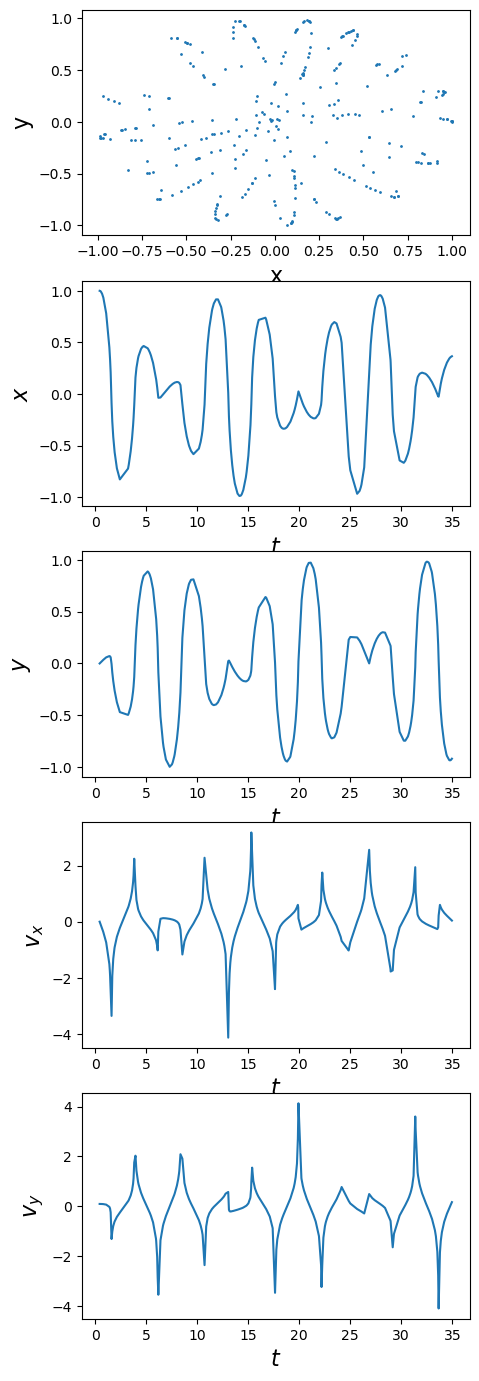

In [383]:
# Graficamos las soluciones

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(5,17))

ax1.plot(x_3,y_3, 'o', ms=1)
ax2.plot(t, x_3)
ax3.plot(t, y_3)
ax4.plot(t, v_x_3)
ax5.plot(t, v_y_3)

ax1.set_ylabel('y', fontsize=16)
ax1.set_xlabel('x', fontsize=16)
ax2.set_xlabel('$t$', fontsize=16)
ax3.set_xlabel('$t$', fontsize=16)
ax4.set_xlabel('$t$', fontsize=16)
ax5.set_xlabel('$t$', fontsize=16)
ax2.set_ylabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax4.set_ylabel('$v_x$', fontsize=16)
ax5.set_ylabel('$v_y$', fontsize=16);

Calculamos el periodograma para las coordenadas x e y:

#### Coordenada X

In [384]:
# Definimos el espacio de frecuencias a analizar

w = np.linspace(0.0001, 10, n_out)
periods = 2 * np.pi / w

# Calculamos el error en frecuencia
err= w[1]-w[0]
err

0.0010000900090009002

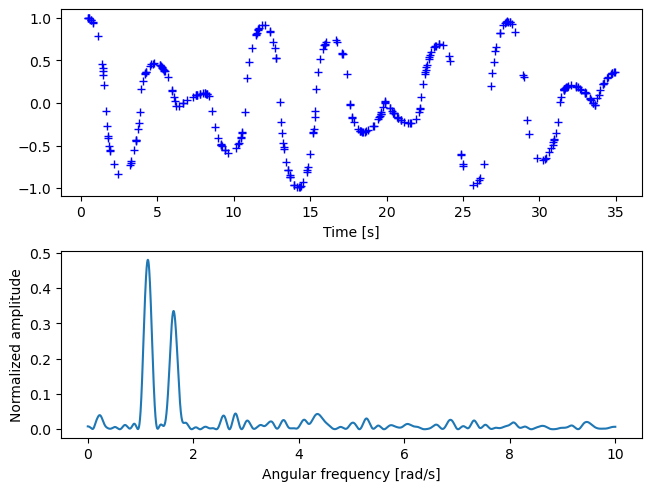

In [385]:
pgram = signal.lombscargle(t, x_3, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, x_3, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude');

Buscamos el valor de la frecuencia del pico mas alto:

In [386]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 1.1392025202520253 0.0010000900090009002


Buscamos el valor de la frecuencia del segundo pico:

In [387]:
pgram2 = np.where(w> 1.3, pgram, pgram*0)

pgram_sort = sorted(enumerate(pgram2), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 1.6262463546354637 0.0010000900090009002


In [388]:
ls = LombScargle(t, x_3, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.47824991499813124
FAP = 1.0186213199697787e-38


In [389]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)

array([0.0657296 , 0.07048172, 0.08109802])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,0657; para el 5%, 0,07048, y para el 1%, 0,08109.

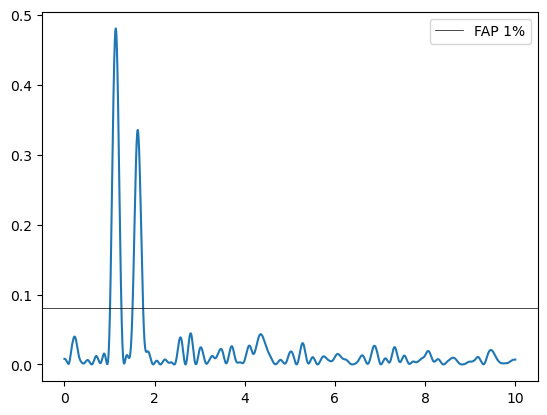

In [390]:
plt.plot(w,pgram)
plt.axhline(0.08109, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron dos picos con una FAP menos a 1%. 

#### Coordenada Y

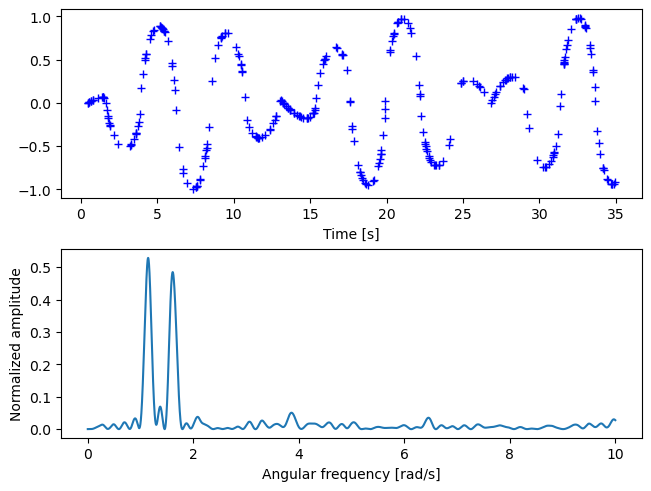

In [391]:
pgram = signal.lombscargle(t, y_3, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, y_3, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude');

Buscamos el valor de la frecuencia del pico mas alto:

In [392]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 1.1442029702970298 0.0010000900090009002


Buscamos el valor de la frecuencia del segundo pico:

In [393]:
pgram2 = np.where(w> 1.3, pgram, pgram*0)

pgram_sort = sorted(enumerate(pgram2), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],  err)

La frecuencia encontrada es 1.6092448244824484 0.0010000900090009002


In [394]:
ls = LombScargle(t, y_3, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.529305547088481
FAP = 2.5761053166919575e-45


In [395]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.0657296 , 0.07048172, 0.08109802])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,06547; para el 5%, 0,0704, y para el 1%, 0,08109.

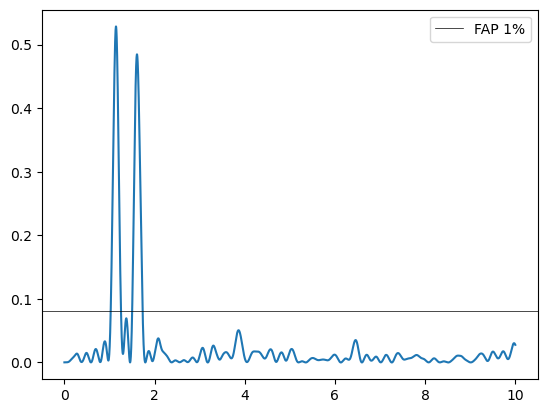

In [396]:
plt.plot(w,pgram)
plt.axhline(0.08109, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron dos picos con un FAP menor al 1%.

### Pasamos ahora a un potencial de la forma:

### $\phi = c(\frac{r_0}{r})^{\alpha}$

Resolvemos el sistema de ecuaciones diferenciales

In [455]:
# Elegimos los tiempos de observación t
seed_value = 40 
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 40, n_in)

In [456]:
t.sort()

In [457]:
# Definimos el sistema de ecuaciones

def f(xyv_xv_y, t, c, r0, alpha):
    x, y, v_x, v_y = xyv_xv_y
    return [v_x, 
           v_y,
           -(c*alpha*x)*(r0/np.sqrt(x**2+y**2))**(alpha-1)*r0/(x**2+y**2)**(3/2),
           -(c*alpha*y)*(r0/np.sqrt(x**2+y**2))**(alpha-1)*r0/(x**2+y**2)**(3/2)]

c, r0, alpha = 1, 1, 0.5

# Condiciónes iniciales
xyv_xv_y0 = [1.0, 0., 0., 0.1]

# Resolvemos las ecuaciones
xyv_xv_y4 = integrate.odeint(f, xyv_xv_y0, t, args=(c, r0, alpha))

In [458]:
x_4 = xyv_xv_y4[:,0]
y_4 = xyv_xv_y4[:,1]
v_x_4 = xyv_xv_y4[:,2]
v_y_4 = xyv_xv_y4[:,3]

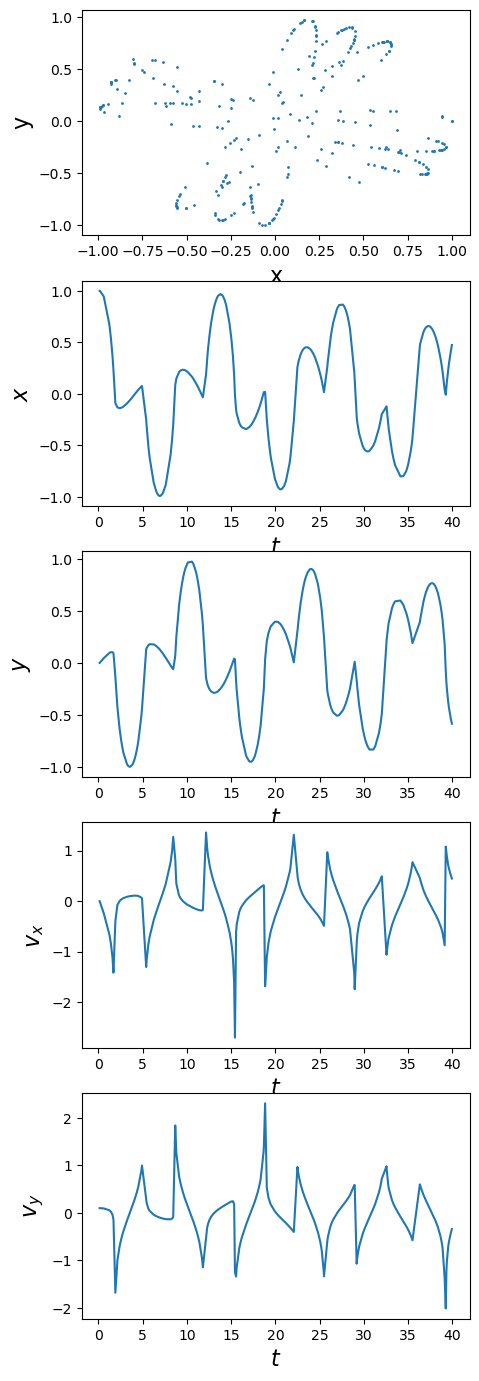

In [459]:
# Graficamos las soluciones

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(5,17))

ax1.plot(x_4,y_4, 'o', ms=1)
ax2.plot(t, x_4)
ax3.plot(t, y_4)
ax4.plot(t, v_x_4)
ax5.plot(t, v_y_4)

ax1.set_ylabel('y', fontsize=16)
ax1.set_xlabel('x', fontsize=16)
ax2.set_xlabel('$t$', fontsize=16)
ax3.set_xlabel('$t$', fontsize=16)
ax4.set_xlabel('$t$', fontsize=16)
ax5.set_xlabel('$t$', fontsize=16)
ax2.set_ylabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax4.set_ylabel('$v_x$', fontsize=16)
ax5.set_ylabel('$v_y$', fontsize=16);

Calculamos el periodograma para las coordenadas x e y:

#### Coordenada X

In [460]:
# Definimos el espacio de frecuencias a analizar

w = np.linspace(0.0002, 20, n_out)
periods = 2 * np.pi / w

# Calculamos el error en frecuencia
err= w[1]-w[0]
err

0.0020001800180018004

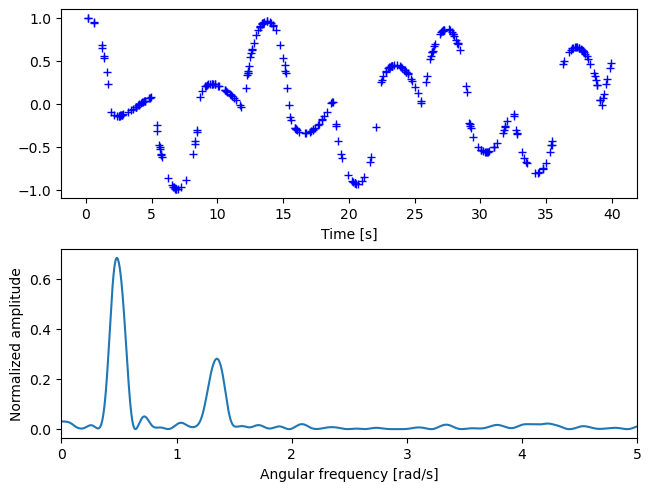

In [461]:
pgram = signal.lombscargle(t, x_4, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, x_4, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
ax_w.set_xlim(0,5);

Buscamos el valor de la frecuencia del pico mas alto:

In [404]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 0.4822433843384339 0.0020001800180018004


Buscamos el valor de la frecuencia del segundo pico:

In [405]:
pgram2 = np.where(w> 1., pgram, pgram*0)

pgram_sort = sorted(enumerate(pgram2), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 1.3503215121512153 0.0020001800180018004


In [406]:
ls = LombScargle(t, x_4, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.6746950816262565
FAP = 5.095458475616379e-69


In [407]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)

array([0.06557543, 0.07032889, 0.08094792])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,06557; para el 5%, 0,07032, y para el 1%, 0,0809.

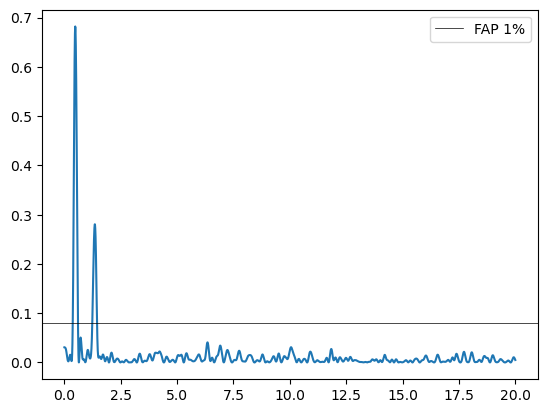

In [409]:
plt.plot(w,pgram)
plt.axhline(0.08094, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron dos picos con una FAP menos a 1%. 

#### Coordenada Y

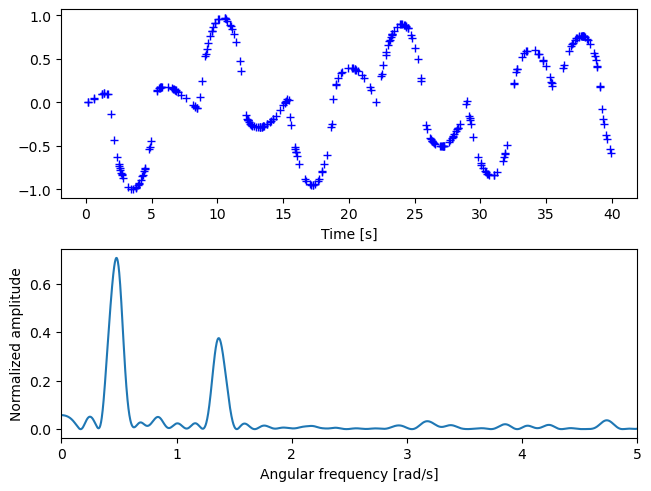

In [410]:
pgram = signal.lombscargle(t, y_4, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, y_4, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
ax_w.set_xlim(0,5);

Buscamos el valor de la frecuencia del pico mas alto:

In [411]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 0.47824302430243026 0.0020001800180018004


Buscamos el valor de la frecuencia del segundo pico:

In [412]:
pgram2 = np.where(w> 1, pgram, pgram*0)

pgram_sort = sorted(enumerate(pgram2), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],  err)

La frecuencia encontrada es 1.3663229522952296 0.0020001800180018004


In [413]:
ls = LombScargle(t, y_4, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.7085794486569812
FAP = 4.4442054078693466e-76


In [414]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)

array([0.06557543, 0.07032889, 0.08094792])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,06557; para el 5%, 0,07032, y para el 1%, 0,08094.

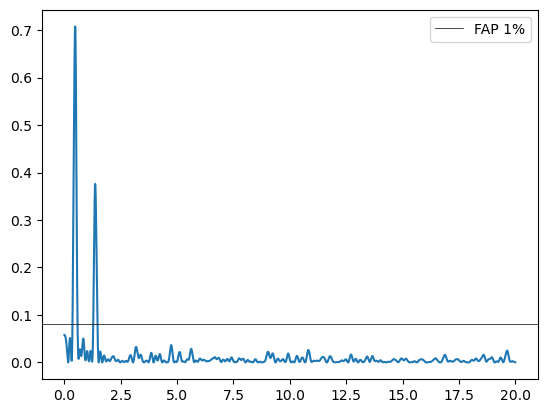

In [415]:
plt.plot(w,pgram)
plt.axhline(0.08094, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron dos picos con una FAP menos a 1%. 

## Pasamos ahora a potenciales con simetria axial

### $\phi(r,z)= \frac{V_o^2}{2}ln(R_c²+r²+\frac{z²}{q²})$ 
#### $\frac{1}{\sqrt{2}}<q\leqslant1$ 

Resolvemos el sistema de ecuaciones diferenciales

In [416]:
# Elegimos los tiempos de observación t
seed_value = 50 
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 45, n_in)

In [417]:
t.sort()

In [418]:
# Definimos el sistema de ecuaciones

def f(rzv_rv_z, t, vo, Rc, q):
    r, z, v_r, v_z = rzv_rv_z
    return [v_r, 
           v_z,
            (-vo**2 *r)/(Rc**2 + r**2 + (z/q)**2),
            (-vo**2 *z)/(q**2) * ((Rc**2 + r**2 + (z/q)**2))]

vo, Rc, q = 1, 0.14, 0.9

# Condiciónes iniciales
rzv_rv_z0 = [0.1, 0.5, 0, 1]

# Resolvemos las ecuaciones
rzv_rv_z1 = integrate.odeint(f, rzv_rv_z0, t, args=(vo, Rc, q))

In [419]:
r1 = rzv_rv_z1[:,0]
z1 = rzv_rv_z1[:,1]
v_r1 = rzv_rv_z1[:,2]
v_z1 = rzv_rv_z1[:,3]

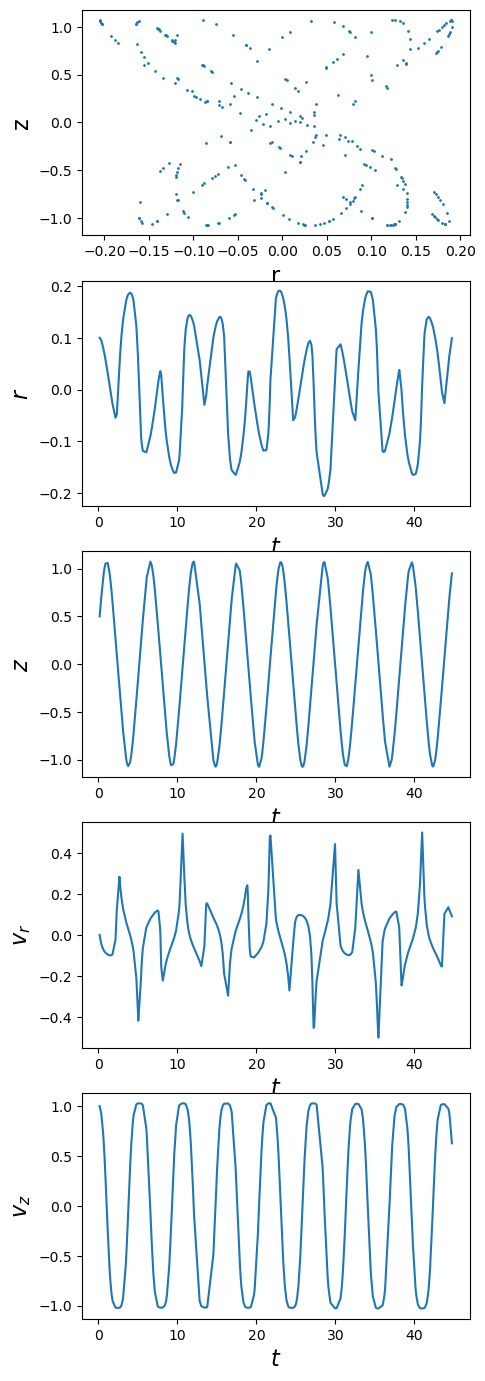

In [420]:
# Graficamos las soluciones

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(5,17))

ax1.plot(r1,z1, 'o', ms=1)
ax2.plot(t, r1)
ax3.plot(t, z1)
ax4.plot(t, v_r1)
ax5.plot(t, v_z1)

ax1.set_ylabel('z', fontsize=16)
ax1.set_xlabel('r', fontsize=16)
ax2.set_xlabel('$t$', fontsize=16)
ax3.set_xlabel('$t$', fontsize=16)
ax4.set_xlabel('$t$', fontsize=16)
ax5.set_xlabel('$t$', fontsize=16)
ax2.set_ylabel('$r$', fontsize=16)
ax3.set_ylabel('$z$', fontsize=16)
ax4.set_ylabel('$v_r$', fontsize=16)
ax5.set_ylabel('$v_z$', fontsize=16);

#### Coordenada r

In [421]:
# Definimos el espacio de frecuencias a analizar

w = np.linspace(0.0001, 10, n_out)
periods = 2 * np.pi / w

# Calculamos el error en frecuencia
err= w[1]-w[0]
err

0.0010000900090009002

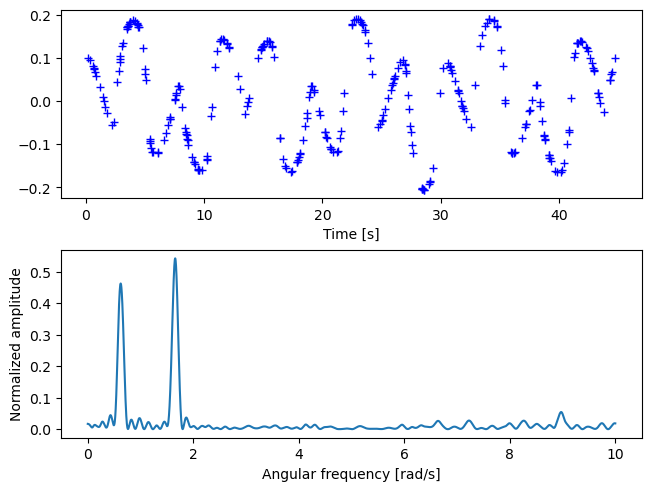

In [422]:
pgram = signal.lombscargle(t, r1, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, r1, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude');

Buscamos el valor de la frecuencia del pico mas alto:

In [423]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 1.6572491449144917 0.0010000900090009002


Buscamos el valor de la frecuencia del segundo pico:

In [424]:
pgram2 = np.where(w< 1, pgram, pgram*0)

pgram_sort = sorted(enumerate(pgram2), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],  err)

La frecuencia encontrada es 0.6241561656165617 0.0010000900090009002


In [425]:
ls = LombScargle(t, r1, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.5368617230653914
FAP = 2.3538117501288214e-46


In [426]:
probabilities = [ 0.1, 0.05, 0.001]
ls.false_alarm_level(probabilities)

array([0.06569807, 0.07045046, 0.09579084])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,06569; para el 5%, 0,07045, y para el 0.1%, 0,09579.

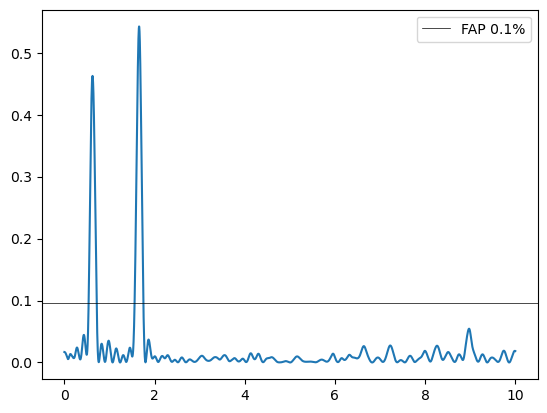

In [427]:
plt.plot(w,pgram)
plt.axhline(0.09579, color= 'black' ,lw=0.5, label=('FAP 0.1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron (uno o dos?) picos con una FAP menor a 0.1%. 

#### Coordenada Z

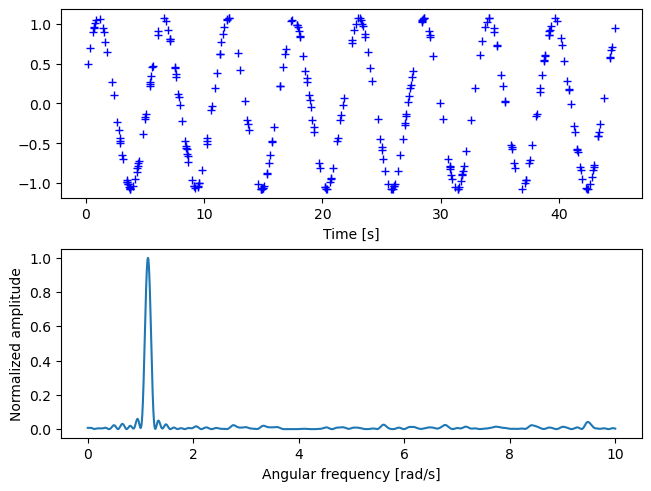

In [428]:
pgram = signal.lombscargle(t, z1, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, z1, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude');

Buscamos el valor de la frecuencia del pico mas alto:

In [429]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 1.1412027002700271 0.0010000900090009002


In [430]:
ls = LombScargle(t, z1, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.9968181213894959
FAP = 0.0


In [431]:
probabilities = [ 0.1, 0.05, 0.001]
ls.false_alarm_level(probabilities)

array([0.06569807, 0.07045046, 0.09579084])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,06569; para el 5%, 0,0704, y para el 1%, 0,09579.

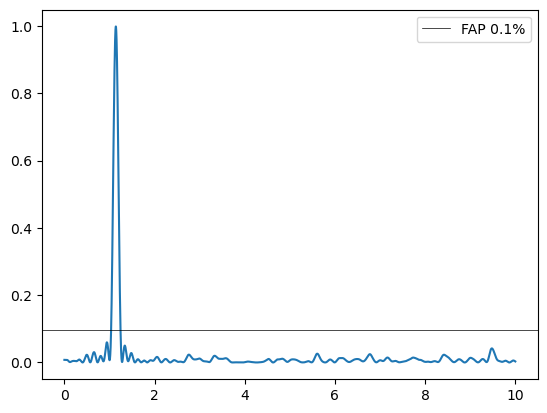

In [432]:
plt.plot(w,pgram)
plt.axhline(0.09579, color= 'black' ,lw=0.5, label=('FAP 0.1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron (uno o dos?) picos con una FAP menor a 0.1%. 

### Por último con
### $\phi(r,z)= \frac{V_o^2}{2}ln(R_c²+r²+\frac{z²}{q²} - \sqrt{(r²+z²)}(r²-z²)/R_e)$ 
#### $\frac{1}{\sqrt{2}}<q\leqslant1$ 
$R_e = 1$

In [433]:
# Elegimos los tiempos de observación t
seed_value = 60 
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 200, n_in*2)

In [434]:
t.sort()

In [435]:
# Definimos el sistema de ecuaciones

def f(rzv_rv_z, t, vo, Rc, q):
    r, z, v_r, v_z = rzv_rv_z
    return [v_r, 
            v_z,
            -vo**2*(-2*r*np.sqrt(r**2+z**2)-((r*(r**2-z**2))/np.sqrt(r**2+z**2))+2*r) / 
            2*(Rc**2+(z/q)**2-((r**2-z**2)*np.sqrt(r**2+z**2))+r**2),  
            
            -vo**2*(2*z*np.sqrt(r**2+z**2)-((z*(r**2-z**2))/np.sqrt(r**2+z**2))+2*z/q**2) / 
            2*(Rc**2+(z/q)**2-((r**2-z**2)*np.sqrt(r**2+z**2))+r**2)]  

vo, Rc, q = 1, 0.14, 0.9

# Condiciónes iniciales
rzv_rv_z0 = [0.1, 0, 0.5, 0.2]

# Resolvemos las ecuaciones
rzv_rv_z2 = integrate.odeint(f, rzv_rv_z0, t, args=(vo, Rc, q))

In [436]:
r2 = rzv_rv_z2[:,0]
z2 = rzv_rv_z2[:,1]
v_r2 = rzv_rv_z2[:,2]
v_z2 = rzv_rv_z2[:,3]

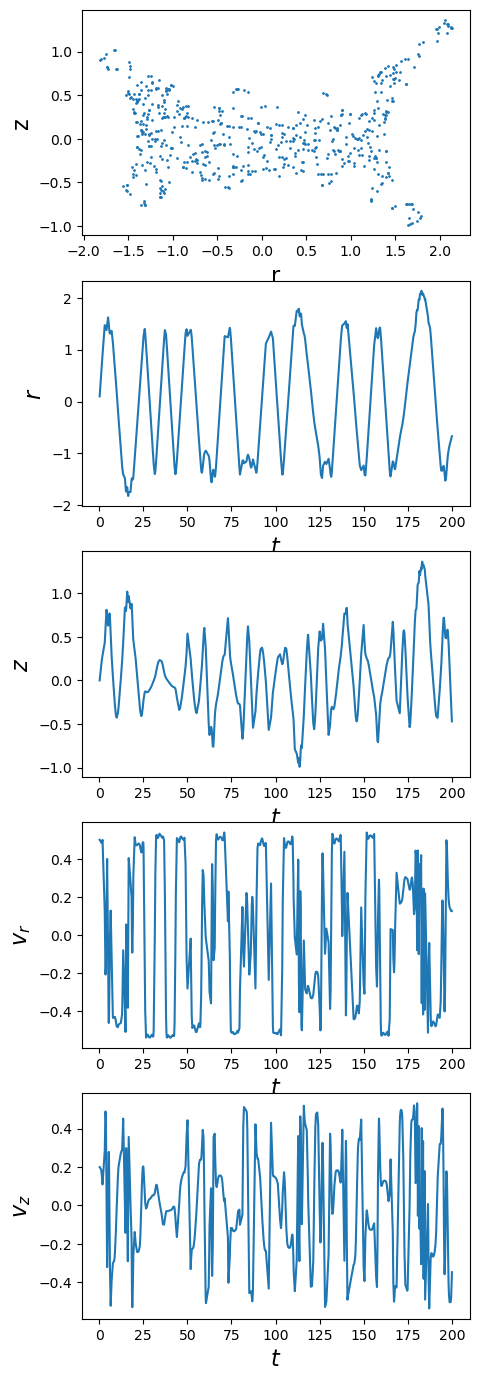

In [437]:
# Graficamos las soluciones

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(5,17))

ax1.plot(r2,z2, 'o', ms=1)
ax2.plot(t, r2)
ax3.plot(t, z2)
ax4.plot(t, v_r2)
ax5.plot(t, v_z2)

ax1.set_ylabel('z', fontsize=16)
ax1.set_xlabel('r', fontsize=16)
ax2.set_xlabel('$t$', fontsize=16)
ax3.set_xlabel('$t$', fontsize=16)
ax4.set_xlabel('$t$', fontsize=16)
ax5.set_xlabel('$t$', fontsize=16)
ax2.set_ylabel('$r$', fontsize=16)
ax3.set_ylabel('$z$', fontsize=16)
ax4.set_ylabel('$v_r$', fontsize=16)
ax5.set_ylabel('$v_z$', fontsize=16);

#### Coordenada r

In [438]:
# Definimos el espacio de frecuencias a analizar

w = np.linspace(0.0001, 10, n_out)
periods = 2 * np.pi / w

# Calculamos el error en frecuencia
err= w[1]-w[0]
err

0.0010000900090009002

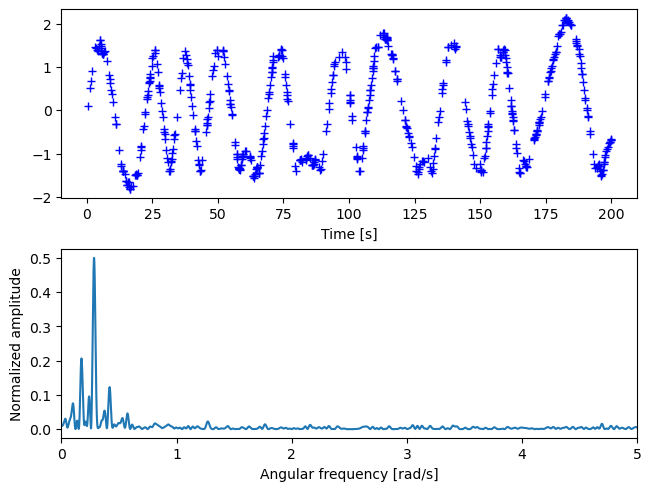

In [443]:
pgram = signal.lombscargle(t, r2, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, r2, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
ax_w.set_xlim(0,5);

Buscamos el valor de la frecuencia del pico mas alto:

In [444]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 0.28312547254725473 0.0010000900090009002


In [445]:
ls = LombScargle(t, r2, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.5007347315305138
FAP = 2.4398261115540834e-86


In [446]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)

array([0.03557323, 0.03800682, 0.04346974])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,06586; para el 5%, 0,07061, y para el 1%, 0,08123.

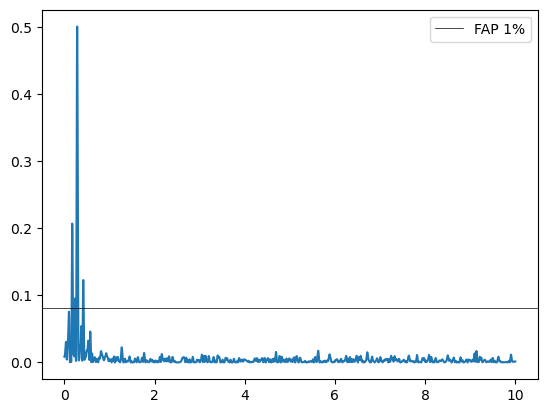

In [447]:
plt.plot(w,pgram)
plt.axhline(0.08123, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontro un pico con una FAP menos a 1%. 

#### Coordenada Z

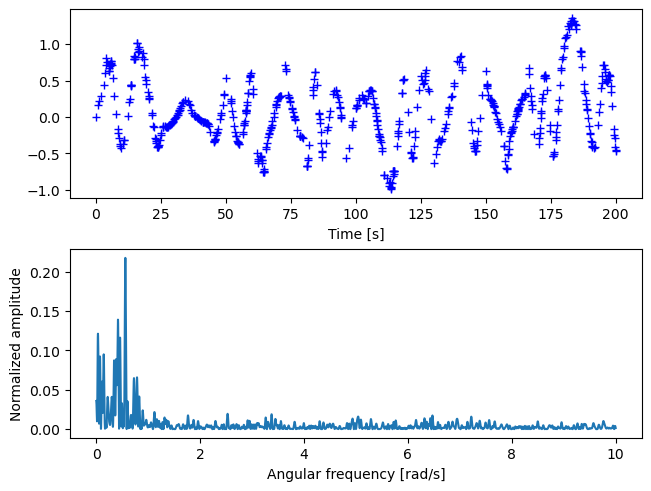

In [449]:
pgram = signal.lombscargle(t, z2, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, z2, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude');

Buscamos el valor de la frecuencia del pico mas alto:

In [450]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 0.5601504050405041 0.0010000900090009002


In [451]:
ls = LombScargle(t, z2, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.21802316416199607
FAP = 1.8873631483961335e-28


In [452]:
probabilities = [ 0.1, 0.05, 0.001]
ls.false_alarm_level(probabilities) 

array([0.03557323, 0.03800682, 0.05110416])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,06586; para el 5%, 0,07061, y para el 1%, 0,09595.

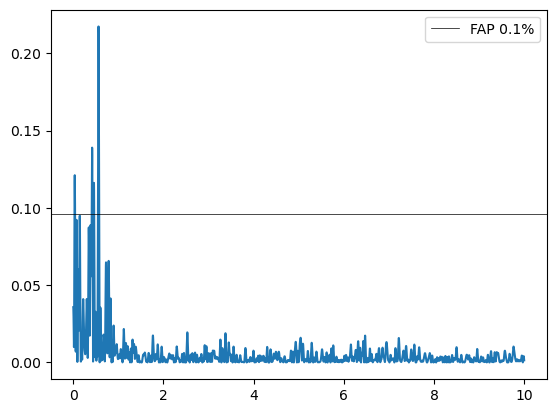

In [453]:
plt.plot(w,pgram)
plt.axhline(0.09595, color= 'black' ,lw=0.5, label=('FAP 0.1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron (uno o dos?) picos con una FAP menor a 0.1%. 